### Binary encoding: l'idea di base
Invece di usare $k$ qubits per nodo (one-hot) usiamo solo $\log_2k$ qbits.
- Ogni colore è rappresentato da una stringa binaria di m = $\lceil\log_2k\rceil$ bit.
- Ogni nodo **v** è rappresentato da un registro di *m* qbits: questi codificano il colore assegnato al nodo.
### Esempio k = 3
Servono *m = 2* qbits per nodo.

Codifica dei colori:
- Colore 0 $\rightarrow$ 00;
- Colore 1 $\rightarrow$ 01;
- Colore 2 $\rightarrow$ 10;
- 11 non è valido $\rightarrow$ va penalizzato.
### Penalità su nodi adiacenti
La codifica binaria garantisce naturalmente il primo vincolo: ogni nodo ha un solo colore.
Rimane da penalizzare tutti quegli stati in cui **due nodi adiacenti hanno la stessa sequenza binaria** (stesso colore).

Supponendo che *u*,*v* siano nodi adiacenti:
- nodo *u* ha qubit [$u_0, u_1, ..., u_{m-1}$];
- nodo *v* ha qubit [$v_0, v_1, ..., v_{m-1}$]

Allora la condizione "uguale colore" si traduce in:
$$ (u_0 == v_0) \; AND \; (u_1 == v_1) \; AND \; ... \; AND \; \dots (u_{m-1} == v_{m-1})$$
Quindi il termine di penalità sarà:
$$H_{uv} = \prod_{l=1}^m\frac{1+Z_{u_l}Z_{v_l}}{2}$$

Esso vale 1 solo se tutte le coppie di bit sono uguali, altrimenti 0.
### Penalizzare codifiche non valide (quando $k<2^m$)
Come nell'esempio precedente, se $k=3$, con $m=2$ qubits, abbiamo $2^m=4$ combinazioni $(00,01,10,11)$, ma solo $3$ valide.

Penalizziamo $11$ con un termine tipo:
$$H_{inv} = \sum_v \text{Proiettore su}\ket{11}_v = \sum_v\frac{1-Z_{v_0}}{2}\frac{1-Z_{v_1}}{2}$$
Infatti, questo termine è minimo (nullo) quando nessun nodo *v* ha entrambi i qubits a $1$.
### Strategia generale
Generalizzando, se abbiamo *n* nodi e *k* colori, usando $m=\lceil\log_2k\rceil$ qubits per ogni nodo, conviene fare prima un check sul numero di colori $k$, poiché le bitstring "non valide" (quelle che non rappresentano nessun colore) vi sono solo quando $k$ non è una potenza di $2$.
$$k < 2^m \implies k < 2^{\lceil\log_2k\rceil}$$
$$\text{n. combinazioni non valide} = 2^m-k$$
Per ognuno di questi stati è possible costruire un proiettore nel modo seguente:
$$P_{inv}^{(b)}=\prod_{l=0}^{m-1}\left(\frac{1+\left(-1\right)^{b_l}Z_{v_l}}{2}\right)$$
Dove $b = \left(b_0,b_1,...,b_{m-1}\right)$ è la stringa binaria non ammessa.

Infine dunque basta sommare su ogni nodo $v$ e ogni stringa binaria non valida:
$$H_{inv} = \sum_v\sum_{non-valid\;b}P_{inv}^{(b)}$$
Questa costruzione è generale per qualsiasi valore di $n,k$.
### Hamiltoniano generale
Dunque, il nostro Hamiltoniano, considerando il protocollo QAOA, sarà:
$$H = H_C + H_M$$

$$H_C = \sum_{(u,v)\in E}H_{uv} + \sum_v\sum_{non-valid \;b}P_{inv}^{(b)} = \sum_{(u,v)\in E}\prod_{l=0}^{m-1}\left(\frac{1+Z_{u_l}Z_{v_l}}{2}\right)+\sum_v\sum_{non-valid \;b}\prod_{l=0}^{m-1}\left(\frac{1+\left(-1\right)^{b_l}Z_{v_l}}{2}\right)$$

$$H_M = \sum_{i=0}^{nm-1}X_i$$


In [6]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
from functools import reduce
import operator

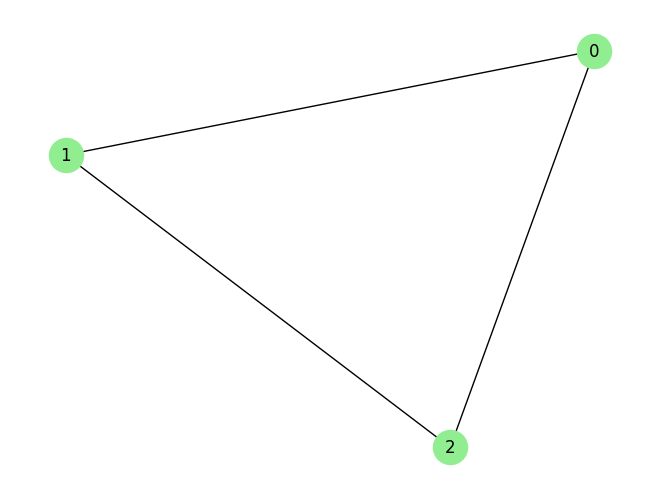

In [7]:
# Parametri
n_nodes = 3
k_colors = 3
edges = [(0, 1), (1, 2), (2, 0)]
graph = nx.Graph()
graph.add_nodes_from(range(n_nodes))
graph.add_edges_from(edges)
positions = nx.spring_layout(graph, seed=1)
#positions = nx.shell_layout(graph)
#positions = nx.kamada_kawai_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color="lightgreen", edge_color="black", node_size=600)
plt.show()

In [8]:
m = int(np.ceil(np.log2(k_colors)))  # qubits per nodo

# Trova il nodo con grado minimo
fixed_node = min(graph.degree, key=lambda x: x[1])[0]
fixed_color = 0

# Bitstring fissa (es. "00" se fixed_color = 0 con k=3)
fixed_bitstring = format(fixed_color, f"0{m}b")
fixed_color_bits = [int(b) for b in format(fixed_color, f"0{m}b")]

In [9]:

# Mapping solo per i nodi NON fissati
active_nodes = [n for n in range(n_nodes) if n != fixed_node]
n_qubits = len(active_nodes) *  m
wires = list(range(n_qubits))

# Qubit per nodo
def qubits_for_node(v):
    assert v != fixed_node, "Nodo fissato non ha qubit"
    idx = active_nodes.index(v) 
    return [idx * m + i for i in range(m)]



In [10]:
# Hamiltoniano di costo
cost_h = qml.Hamiltonian([], [])  # inizializzazione esplicita

# --- Penalità: nodi adiacenti con stesso colore ---
fixed_color_bits = [int(b) for b in format(fixed_color, f"0{m}b")]
for (u, v) in edges:
    # Se entrambi NON sono il nodo fissato
    if u != fixed_node and v != fixed_node:
        terms = []
        for i in range(m):
            op = (qml.PauliZ(qubits_for_node(u)[i]) @ qml.PauliZ(qubits_for_node(v)[i]))
            terms.append((1 + op) / 2)
        penalty = reduce(operator.matmul, terms)
        cost_h += penalty
    else:
        # Solo uno dei due è il nodo fissato
        unfixed = v if u == fixed_node else u
        proj_terms = []
        for i in range(m):
            z = qml.PauliZ(qubits_for_node(unfixed)[i])
            coeff = (-1)**fixed_color_bits[i]
            proj_terms.append((1 + coeff * z) / 2)
        projector = reduce(operator.matmul, proj_terms)
        cost_h += projector

# --- Penalità: codifiche non valide (se k < 2^m) ---
invalid_bitstrings = [b for b in product([0, 1], repeat=m) if int("".join(map(str, b)), 2) >= k_colors]

for v in range(n_nodes):
    if (v == fixed_node):
        continue
    q_v = qubits_for_node(v)
    for b in invalid_bitstrings:
        proj_terms = []
        for i in range(m):
            z = qml.PauliZ(q_v[i])
            coeff = (-1)**b[i]
            proj_terms.append((1 + coeff * z) / 2)

        proj = reduce(operator.matmul, proj_terms)
        cost_h += proj
cost_h = cost_h*10


In [11]:
# Mixer Hamiltonian
mixer_h = qml.Hamiltonian([], [])
for w in wires:
    mixer_h += qml.PauliX(w)

In [12]:
# QAOA layer
def qaoa_layer(gamma, alpha):
    qml.ApproxTimeEvolution(cost_h, gamma, 1)
    qml.ApproxTimeEvolution(mixer_h, alpha, 1)


In [13]:
# Circuito
depth = 1
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [14]:
# Device
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)


In [15]:
# Ottimizzazione
optimizer = qml.AdamOptimizer()
steps = 100
params = np.array([[0.5] * depth, [0.5] * depth], requires_grad=True)

patience = 6          
min_delta = 0.001        
counter = 0
cost_history = []
best_cost = np.inf
best_params = None

for step in tqdm(range(steps), desc="Training Progress"):
    cost = cost_function(params)
    cost_history.append(cost)

    # Early stopping logic
    if best_cost - cost > min_delta:
        best_cost = cost
        best_params = params.copy()
        counter = 0
    else:
        counter += 1

    # Check stop condition
    if counter >= patience:
        print(f"Early stopping at step {step}")
        break

    params = optimizer.step(cost_function, params)

print("Miglior costo trovato:", best_cost)
print("Parametri corrispondenti:", best_params)

Training Progress:  21%|██        | 21/100 [00:01<00:03, 19.81it/s]

Early stopping at step 21
Miglior costo trovato: 6.49228707754971
Parametri corrispondenti: [[0.54092204]
 [0.35405066]]


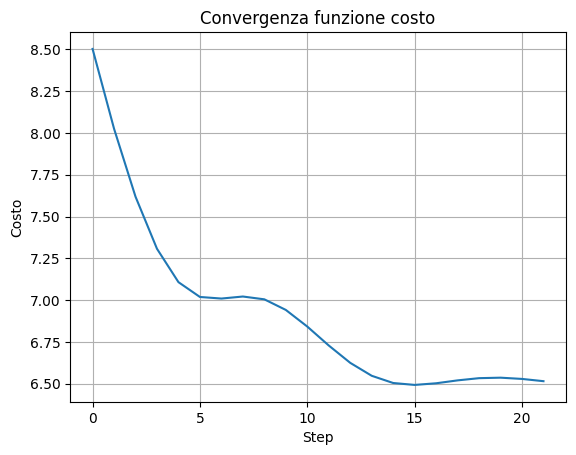

In [16]:
# Plot convergenza
plt.plot(cost_history)
plt.title("Convergenza funzione costo")
plt.xlabel("Step")
plt.ylabel("Costo")
plt.grid(True)
plt.show()

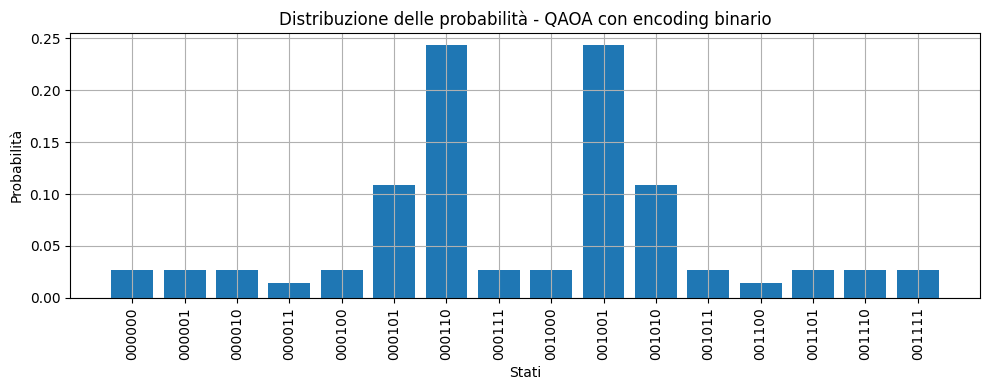

In [17]:
# Probabilità finali
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(best_params[0], best_params[1])

# Bitstring completa (include nodo fissato)
def insert_fixed_bitstring(raw_bitstring, fixed_node, fixed_bitstring, n_nodes, k_colors):
    chunks = []
    active_index = 0
    for node in range(n_nodes):
        if node == fixed_node:
            chunks.append(fixed_bitstring)
        else:
            start = active_index * m
            end = (active_index + 1) * m
            chunks.append(raw_bitstring[start:end])
            active_index += 1
    return ''.join(chunks)

bitstrings = []
for i in range(2**n_qubits):
    raw = format(i, f"0{n_qubits}b")
    full = insert_fixed_bitstring(raw, fixed_node, fixed_bitstring, n_nodes, k_colors)
    bitstrings.append(full)

# Istogramma
plt.figure(figsize=(10, 4))
plt.bar(bitstrings, probs)
plt.xticks(rotation=90)
plt.xlabel("Stati")
plt.ylabel("Probabilità")
plt.title("Distribuzione delle probabilità - QAOA con encoding binario")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Analisi risultati
def decode_binary(bitstring, m):
    return int(bitstring, 2)

def decode_bitstring(bitstring, n_nodes, m, fixed_node, fixed_color):
    assignment = {fixed_node: fixed_color}
    active_index = 0
    for node in range(n_nodes):
        if node == fixed_node:
            continue
        
        bits = bitstring[active_index:active_index + m]
        color = int(bits, 2)  # converte la sottostringa binaria in intero
        assignment[node] = color
        
        active_index += m
        
    return assignment

def analyze_binary_results(probs, n_nodes, m, k_colors, edges, threshold=None):
    if threshold is None:
        threshold = max(probs) - 1e-7

    print("Bitstring | Assegnamento | Valido | Probabilità")
    print("-" * 50)
    deg = 0
    outcome = False
    best_assignment = None

    for i, p in enumerate(probs):
        if p > threshold:

            bitstring = format(i, f"0{n_qubits}b")
            assignment = decode_bitstring(bitstring, n_nodes, m, fixed_node, fixed_color)
            valid = True
            bitstring_full = insert_fixed_bitstring(bitstring, fixed_node, fixed_bitstring, n_nodes, m)            

            for v in range(n_nodes):
                if v==fixed_node:
                    continue
                bits = bitstring_full[v * m:(v + 1) * m]
                color = decode_binary(bits, m)
                assignment[v] = color
                if color >= k_colors:
                    valid = False

            for u, v in edges:
                if assignment[u] == assignment[v]:
                    valid = False

            print(f"{bitstring_full} | {assignment} | {valid} | {p}")
            if valid:
                deg += 1
                best_assignment = assignment
                outcome = True

    return best_assignment, outcome, deg

assignment, outcome, deg = analyze_binary_results(probs, n_nodes, m, k_colors, edges)

Bitstring | Assegnamento | Valido | Probabilità
--------------------------------------------------
000110 | {0: 0, 1: 1, 2: 2} | True | 0.24327501200283386
001001 | {0: 0, 1: 2, 2: 1} | True | 0.24327501200283386


In [19]:
#Output: numero cromatico
if outcome:
    print(f"Il numero minimo di colori per colorare il grafo è {k_colors}")
else:
    print(f"{k_colors} NON è il numero cromatico del grafo")

Il numero minimo di colori per colorare il grafo è 3


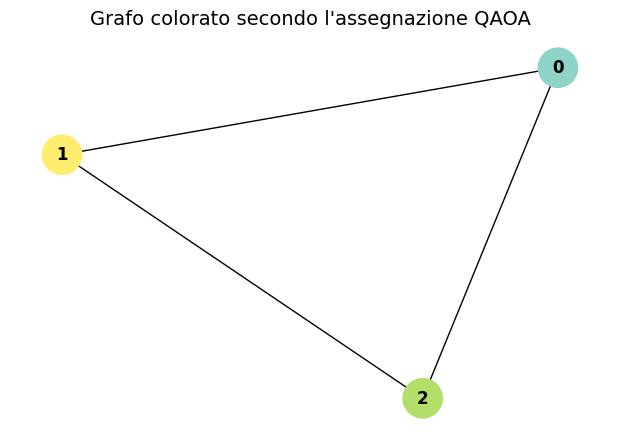

In [20]:
# Visualizzazione grafo colorato
def plot_colored_graph(graph, assignment, positions, cmap=plt.cm.Set3):
    node_colors = [assignment[n] for n in graph.nodes]
    unique_colors = sorted(set(node_colors))
    n_colors = len(unique_colors)
    color_list = [cmap(i / max(1, n_colors - 1)) for i in range(n_colors)]
    color_map = {c: color_list[i] for i, c in enumerate(unique_colors)}
    final_colors = [color_map[c] for c in node_colors]

    plt.figure(figsize=(6, 4))
    nx.draw(
        graph,
        pos=positions,
        with_labels=True,
        node_color=final_colors,
        edge_color="black",
        node_size=800,
        font_color="black",
        font_weight="bold"
    )
    plt.title("Grafo colorato secondo l'assegnazione QAOA", fontsize=14)
    plt.axis('off')
    plt.show()

if assignment:
    plot_colored_graph(graph, assignment, positions)